# STL and ARIMA

In [55]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import plotly.express as px
from sklearn.utils import resample  # For bootstrapping
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA


## Load data

In [56]:
# Read excel in ../Data/Clean_McBroken_Daily.xlsx
df = pd.read_excel('../Data/Clean_McBroken_Daily.xlsx')
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2020-10-25,354.0,6818.0,5.192138,221250.0,False,True
1,2020-10-26,373.0,6844.0,5.450029,233125.0,False,True
2,2020-10-27,427.0,7488.0,5.702457,266875.0,False,True
3,2020-10-28,391.0,8294.0,4.714251,244375.0,False,True
4,2020-10-29,374.0,7461.0,5.012733,233750.0,False,True
...,...,...,...,...,...,...,...
1571,2025-02-12,1277.0,11636.0,10.974562,798125.0,False,False
1572,2025-02-13,1189.0,11707.0,10.156317,743125.0,False,False
1573,2025-02-14,1068.0,11428.0,9.345467,667500.0,False,False
1574,2025-02-15,1107.0,11773.0,9.402871,691875.0,False,False


## STL and ARIMA

In [57]:
# Count missing and outlier cases
print('Missing cases:', df['Revenue Losses'].isnull().sum())
# Mark missing cases
df['Missing'] = df['Revenue Losses'].isnull()
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 129
Outlier cases: 119


In [58]:
# Revenue Losses
fig = px.line(df, x='Date', y='Revenue Losses',
              title='Revenue Losses From Broken Machines ($625 per day per machine)',
              labels={'Revenue Losses': 'Revenue Losses'},
              line_shape='linear')

# Center title
fig.update_layout(title_x=0.5)

# Dollar format
fig.update_layout(yaxis_tickprefix='$')

# Show the plot
fig.show()

In [59]:
# Set Outlier values to missing
df.loc[df['Outlier'], 'Revenue Losses'] = None

# While loop to fill with 7 day lags
# Alternate between computing 7 day lags
# and filling missing values with 7 day lags
while df['Revenue Losses'].isnull().sum() > 0:
    # Compute 7 day lags
    df['7-day lag'] = df['Revenue Losses'].shift(7)
    # Fill missing values with 7 day lags
    df['Revenue Losses'] = df['Revenue Losses'].fillna(df['7-day lag'])

In [60]:
# Revenue Losses
fig = px.line(df, x='Date', y='Revenue Losses',
              title='Revenue Losses From Broken Machines ($625 per day per machine)',
              labels={'Revenue Losses': 'Revenue Losses'},
              line_shape='linear')

# Center title
fig.update_layout(title_x=0.5)

# Dollar format
fig.update_layout(yaxis_tickprefix='$')

# Show the plot
fig.show()

In [61]:
# For this model, limit data to last year
# This will both take care of outliers and minimize missing data
df = df[df['Date'] >= df['Date'].max() - pd.DateOffset(years=1)].reset_index(drop=True)
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train,Missing,7-day lag
0,2024-02-16,241.0,3974.0,6.064419,1012500.0,True,True,False,1012500.0
1,2024-02-17,1511.0,15466.0,9.769818,944375.0,False,True,False,950625.0
2,2024-02-18,1816.0,15880.0,11.435768,1135000.0,False,True,False,1088125.0
3,2024-02-19,2004.0,15851.0,12.642735,1252500.0,False,True,False,1136875.0
4,2024-02-20,1908.0,15908.0,11.993965,1192500.0,False,True,False,1083125.0
...,...,...,...,...,...,...,...,...,...
362,2025-02-12,1277.0,11636.0,10.974562,798125.0,False,False,False,773125.0
363,2025-02-13,1189.0,11707.0,10.156317,743125.0,False,False,False,736875.0
364,2025-02-14,1068.0,11428.0,9.345467,667500.0,False,False,False,679375.0
365,2025-02-15,1107.0,11773.0,9.402871,691875.0,False,False,False,694375.0


In [62]:
# Count missing and outlier cases
print('Missing cases:', df['Missing'].sum())
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 3
Outlier cases: 35


In [63]:
df = df[['Date', 'Revenue Losses', 'Train']]
df

,Date,Revenue Losses,Train
0,2024-02-16,1012500.0,True
1,2024-02-17,944375.0,True
2,2024-02-18,1135000.0,True
3,2024-02-19,1252500.0,True
4,2024-02-20,1192500.0,True
...,...,...,...
362,2025-02-12,798125.0,False
363,2025-02-13,743125.0,False
364,2025-02-14,667500.0,False
365,2025-02-15,691875.0,False


In [64]:
# Train/test split
train_df = df.query('Train == 1').reset_index(drop=True)
test_df = df.query('Train == 0').reset_index(drop=True)
print(len(train_df), len(test_df))

337 30


Seasonally Adjusted Data:
0      19533.316196
1     -72563.389115
2     -33377.124766
3      35262.862479
4      20274.023193
           ...     
332   -22862.137521
333   -28475.976807
334    89431.987160
335   -60353.766985
336   -37446.913395
Name: resid, Length: 337, dtype: float64


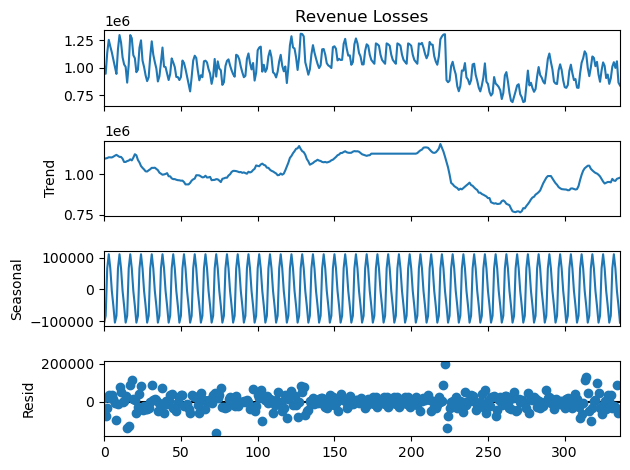

In [73]:
# 1. STL Decomposition
decomposition = seasonal_decompose(train_df['Revenue Losses'], model='additive', period=7, extrapolate_trend='freq')
seasonally_adjusted = decomposition.resid
print('Seasonally Adjusted Data:')
print(seasonally_adjusted)
# Plot the Decomposition Components
decomposition.plot()  # Plots original, trend, seasonal, and residual
plt.show()

In [ ]:
# 2. auto_arima on Seasonally Adjusted Data
auto_model = auto_arima(seasonally_adjusted, seasonal=False,  # Important: seasonal=False
                        stepwise=True, trace=True,
                        suppress_warnings=True, error_action='ignore')
best_order = auto_model.order  # Get the best (p, d, q) order
print('optimal order: ', best_order)

In [ ]:
# 3. STLForecast with the Determined Order
stlf = STLForecast(train_df['Revenue Losses'], ARIMA, model_kwargs={"order": best_order}, period=7) # Use the found order
stlf_fitted = stlf.fit()

stlf_fitted_values = stlf_fitted.get_prediction(0, len(train_df) - 1).predicted_mean
stlf_residuals = train_df['Revenue Losses'] - stlf_fitted_values

# Get forecast
test_forecast = stlf_fitted.forecast(30)

In [66]:
# Check residuals
def plot_stlforecast_residuals(fit, lags=10, bins=20):
    """
    Generates and displays a suite of residual plots for STLForecast.

    Args:
        fit: The fitted STLForecast model object (result of fit()).
        lags: Number of lags to plot in the ACF.
        bins: Number of bins for the histogram.
    """

    fitted_values = fit.get_prediction(0, len(train_df) - 1).predicted_mean
    residuals = train_df['Revenue Losses'] - fitted_values

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    # 1. Time Series Plot of Residuals
    axes[0, 0].plot(residuals)
    axes[0, 0].set_title('Residuals over Time')
    axes[0, 0].set_xlabel('Date')  # Or time index
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True)

    # 2. Histogram of Residuals
    axes[0, 1].hist(residuals, bins=bins)
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals')

    # 4. ACF Plot
    plot_acf(residuals, lags=lags, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelation Function (ACF)')

    # 5. Residuals vs. Fitted Values
    axes[2, 0].scatter(fitted_values, residuals)
    axes[2, 0].set_title('Residuals vs. Fitted Values')
    axes[2, 0].set_xlabel('Fitted Values')
    axes[2, 0].set_ylabel('Residuals')
    axes[2, 0].grid(True)

    fig.delaxes(axes[2,1]) # Remove the unnecessary subplot

    plt.tight_layout()
    plt.show()

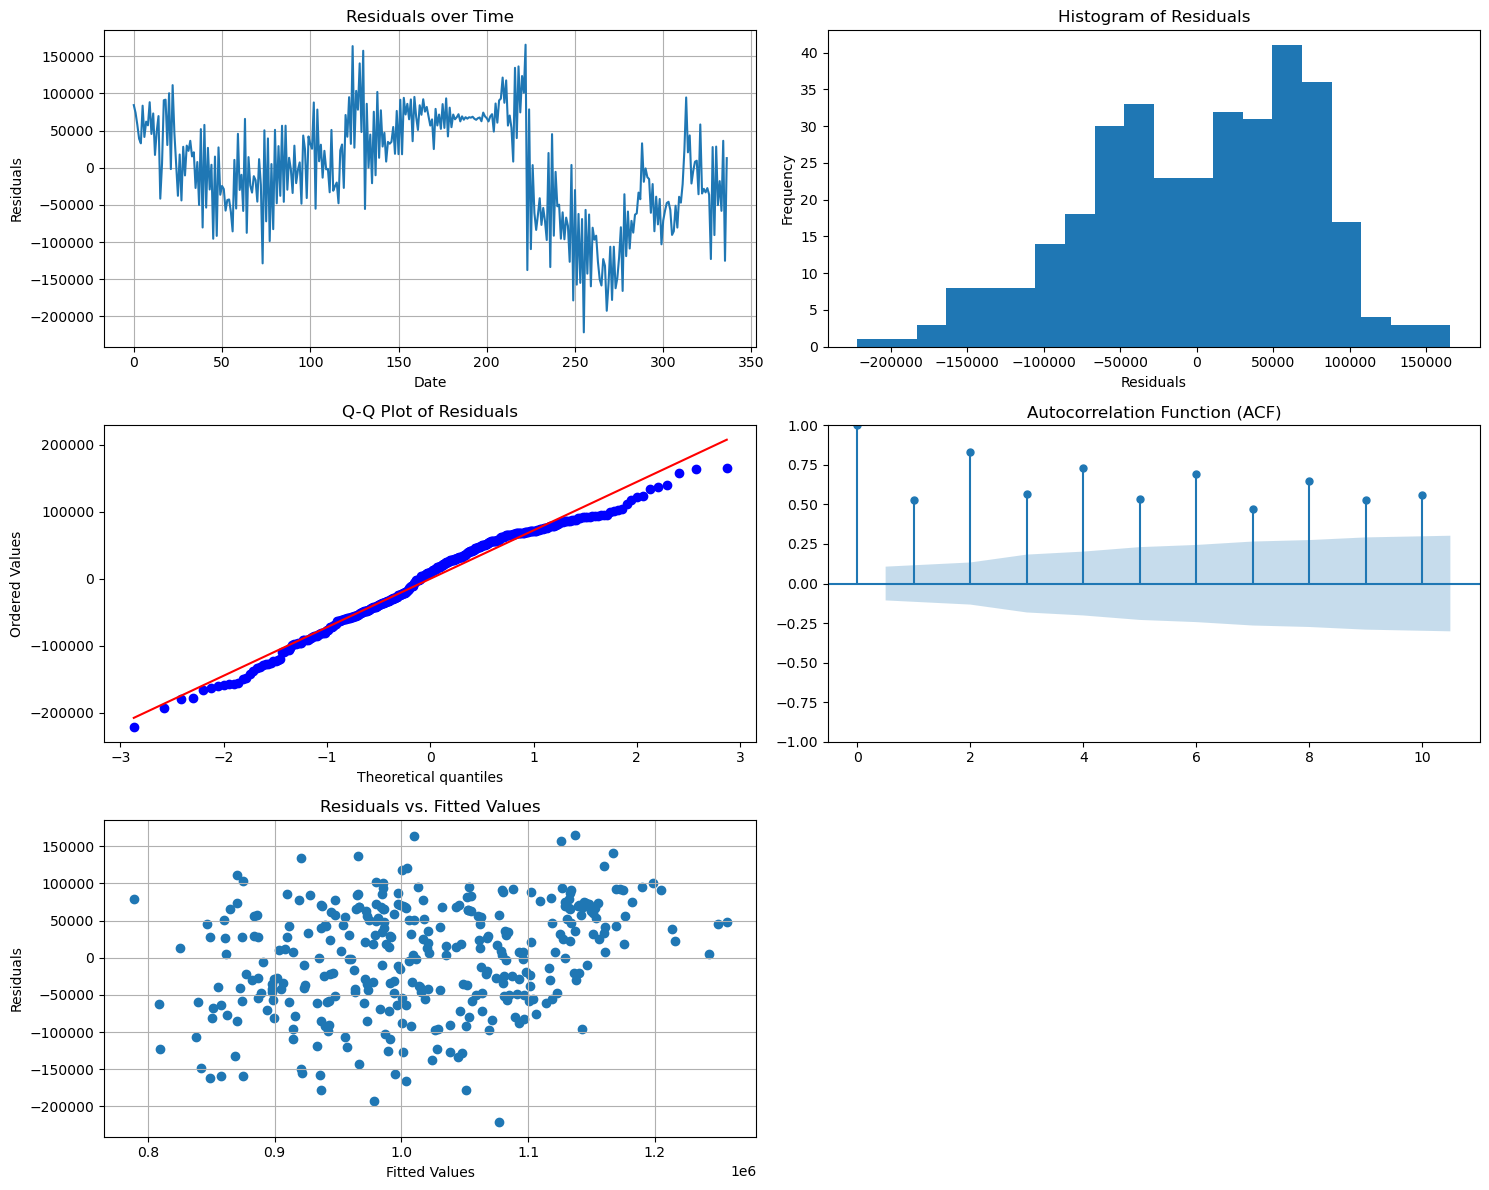

In [67]:
plot_stlforecast_residuals(stlf_fitted)

In [70]:
# 1. Get Residuals from the Training Data
train_residuals = stlf_residuals

# 2. Bootstrapping Function
def bootstrap_forecast(train_data, train_residuals, test_len, n_bootstraps=500):
    forecasts = []
    for _ in range(n_bootstraps):
        # 2a. Resample Residuals with Replacement
        resampled_residuals = list(resample(train_residuals, replace=True))

        # 2b. Create "Bootstrapped" Training Data
        bootstrapped_train = train_data + resampled_residuals

        # Forecasting steps:

        # 1. STL Decomposition
        boot_decomposition = seasonal_decompose(bootstrapped_train, model='additive', period=7, extrapolate_trend='freq')
        boot_seasonally_adjusted = boot_decomposition.resid

        # 2. auto_arima on Seasonally Adjusted Data
        boot_auto_model = auto_arima(boot_seasonally_adjusted, seasonal=False,  # Important: seasonal=False
                                stepwise=True, trace=True,
                                suppress_warnings=True, error_action='ignore')
        boot_best_order = boot_auto_model.order  # Get the best (p, d, q) order
        print('optimal order: ', boot_best_order)

        # 3. STLForecast with the Determined Order
        boot_stlf = STLForecast(bootstrapped_train, ARIMA, model_kwargs={"order": best_order}, period=7)
        boot_stlf_fitted = boot_stlf.fit()

        # Get forecast
        boot_forecast = boot_stlf_fitted.forecast(test_len)
        forecasts.append(boot_forecast)

    return np.array(forecasts)  # Return as a NumPy array for easier manipulation

# 3. Generate Bootstrapped Forecasts
n_bootstraps = 500  # Number of bootstrap iterations (adjust as needed)
boot_forecasts = bootstrap_forecast(train_df['Revenue Losses'], stlf_residuals, len(test_df), n_bootstraps)

# 4. Calculate Prediction Intervals
alpha = 0.05  # Significance level (for 95% interval)
lower_bounds = np.percentile(boot_forecasts, (alpha / 2) * 100, axis=0)  # Lower percentile
upper_bounds = np.percentile(boot_forecasts, (1 - alpha / 2) * 100, axis=0)  # Upper percentile

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8536.274, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8537.162, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8535.733, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.655 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8560.095, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8559.503, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8539.781, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8509.516, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8474.902, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8457.107, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8459.100, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.873 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.454, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.272, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8523.814, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8491.206, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8472.774, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8451.631, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8453.614, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.940 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8544.269, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8544.085, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8530.955, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8484.635, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.182, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8450.795, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8452.803, Time=0.07 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.815 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8505.508, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8502.044, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8486.543, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8454.821, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8444.728, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8432.709, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8434.708, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.868 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8479.728, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8465.671, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8453.488, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8418.198, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8405.203, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8377.912, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8379.912, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.818 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8531.154, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8530.470, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8505.655, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8465.555, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8452.535, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8438.875, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8440.808, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.972 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.960, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.192, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8541.951, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.434 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8482.402, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8473.775, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8467.143, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8420.369, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8403.825, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8382.911, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8384.903, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.926 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.247, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8547.817, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8538.045, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8502.314, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8483.332, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8466.526, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8468.511, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.054 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8544.873, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8542.993, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8519.154, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8486.206, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8473.211, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8453.755, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8455.756, Time=0.07 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.898 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8551.278, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8547.854, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8541.509, Time=0.00 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8494.420, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8484.676, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8470.130, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8472.112, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.884 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8519.100, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8520.419, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8521.092, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.398 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8589.879, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8580.327, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8563.726, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8489.304, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8480.140, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8471.605, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8473.589, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.965 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8528.975, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8524.320, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8510.284, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8445.247, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8428.624, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8419.663, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8421.684, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.230 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8540.301, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8538.477, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8530.352, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8461.667, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8446.885, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8441.803, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8443.792, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.976 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8524.685, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8517.968, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8483.305, Time=0.02 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8459.810, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8457.679, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8438.586, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8440.597, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.117 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8595.419, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8586.869, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8556.216, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8528.058, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8517.361, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8498.697, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8500.659, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.950 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8553.909, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8551.220, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8541.694, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8494.009, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.777, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8474.939, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8476.940, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.096 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.013, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8527.255, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8518.702, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8471.924, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8466.558, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8454.937, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8456.926, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.001 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.586, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8556.339, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8556.090, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8556.525, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.321 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8571.316, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8570.550, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8553.744, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8501.046, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8486.122, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8462.807, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8464.769, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.966 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8524.299, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8521.818, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8495.014, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8470.511, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8464.125, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8449.339, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8451.329, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.917 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8611.429, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8609.406, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8592.929, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8534.805, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8527.640, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8512.864, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8514.867, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.902 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8525.056, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8524.456, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8503.799, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8464.902, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8445.566, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8420.435, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8422.453, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.993 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8522.501, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8512.799, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8501.041, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8448.896, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8433.020, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8424.459, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8426.457, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.993 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.628, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.726, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8536.835, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8511.559, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8483.261, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8460.000, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8461.989, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.166 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8560.896, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8560.558, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8529.105, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8488.958, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8485.313, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8464.999, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8467.002, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.000 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8542.896, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8536.874, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8528.080, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8495.550, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8480.091, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8464.397, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8466.377, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.918 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8559.485, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8559.567, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8561.480, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.564 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8551.201, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8550.467, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8530.260, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8479.962, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8465.567, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8433.725, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8435.723, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.975 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8521.722, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8520.832, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8504.292, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8444.036, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8433.969, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8423.364, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8425.362, Time=0.07 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.062 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8542.265, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8538.029, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8513.033, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8478.787, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8466.317, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8448.724, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8450.714, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.098 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8548.112, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8546.544, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8527.392, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8472.429, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8461.161, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8434.205, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8436.186, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.067 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8574.832, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8573.823, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8545.866, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8494.939, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8483.231, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8473.316, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8475.313, Time=0.06 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.921 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.139, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.430, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8539.467, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8541.139, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.372 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8593.666, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8594.715, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8595.649, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.398 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8514.403, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8509.084, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8479.998, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8452.540, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8438.639, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8427.623, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8429.612, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.077 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8545.154, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.541, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8512.379, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8472.956, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8456.809, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8452.296, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8454.295, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.963 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8520.642, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8507.158, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8497.484, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8464.839, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8446.317, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8443.265, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8445.265, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.107 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8572.848, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8571.895, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8548.163, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8499.401, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8489.658, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8457.639, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8459.638, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.043 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8600.330, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8600.109, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8593.146, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8533.393, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8516.988, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8492.306, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8494.260, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.023 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8550.525, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8544.158, Time=0.02 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8537.364, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8497.311, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.500, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8456.516, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8458.522, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.976 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8564.169, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8561.615, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8560.750, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8498.773, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8488.213, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8429.041, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8431.043, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.045 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.572, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.335, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8541.570, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.411 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8536.481, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8522.843, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8510.805, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8470.295, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8469.740, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8448.829, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8450.831, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.006 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8597.983, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8594.900, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8573.368, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8524.984, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8523.432, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8489.191, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8491.191, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.992 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8504.147, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8502.567, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8487.205, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8446.389, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8437.500, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8422.172, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8424.178, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.143 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8543.165, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.017, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8517.471, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8474.005, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8465.220, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8438.530, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8440.534, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.022 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8570.433, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8569.106, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8539.199, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8507.420, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8497.306, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8484.980, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8487.013, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.014 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8500.586, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8502.105, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8502.577, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.331 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.875, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8534.376, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8512.953, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8483.560, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8469.547, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8464.890, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8466.880, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.983 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8548.946, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8546.597, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8499.481, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8456.317, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8442.449, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8424.290, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8426.285, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.142 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8595.781, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8597.773, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8597.756, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8597.706, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.466 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8541.500, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.184, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8542.560, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8543.499, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.408 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8538.408, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8538.409, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8540.387, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.397 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8569.028, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8558.563, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8543.326, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8508.364, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8499.582, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8493.925, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8495.926, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.031 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8543.492, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8538.758, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8518.471, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8476.204, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8461.773, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8449.301, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8451.279, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.031 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.521, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8553.314, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8523.352, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8458.248, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8459.575, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8460.249, Time=0.05 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.051 seconds
optimal order:  (3, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8576.975, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8574.951, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8559.555, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8534.354, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8520.561, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8505.143, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8507.102, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.024 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8573.455, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8567.597, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8541.878, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8508.293, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8500.098, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8473.271, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8475.275, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.184 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.154, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8545.803, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8533.759, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8490.852, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8475.831, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8463.803, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8465.743, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.140 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8555.277, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8554.983, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8538.948, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8490.791, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8481.272, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8451.439, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8453.444, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.102 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8513.350, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8513.348, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8501.065, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8459.129, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8433.323, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8426.032, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8428.028, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.998 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.223, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8545.881, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8528.457, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8487.561, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8477.364, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8459.324, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8461.308, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.092 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8586.708, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8587.092, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8588.654, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.443, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8558.171, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8530.904, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8468.703, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8462.330, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8451.183, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8453.216, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.003 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8630.300, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8628.454, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8604.159, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8543.538, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8530.743, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8512.409, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8514.382, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.938 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8567.041, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8567.446, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8569.023, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.419 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8566.662, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8562.321, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8540.405, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8495.932, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8491.992, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8461.421, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8463.407, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.225 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8533.033, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8529.950, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8518.497, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8471.493, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8467.708, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8436.015, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8438.008, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.060 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8535.029, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8536.688, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8536.477, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8537.017, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.349 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8549.729, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8545.200, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8532.574, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8489.038, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8473.148, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8440.715, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8442.707, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.976 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8553.306, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8552.387, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8544.211, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8496.781, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8477.691, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8464.353, Time=0.05 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8466.344, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.961 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8550.190, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8542.232, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8532.837, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8509.124, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8498.624, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8478.678, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8480.677, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.078 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8535.610, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8536.286, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8537.597, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.316 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8579.949, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8581.047, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8580.104, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8581.949, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.438 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8528.216, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8522.850, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8507.689, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8468.379, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8455.512, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8425.789, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8427.793, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.247 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8536.519, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8538.189, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8537.824, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8538.506, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.405 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8514.114, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8512.814, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8511.271, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8513.278, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.607 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8548.686, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8545.204, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8530.228, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8503.693, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8495.440, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8478.008, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8479.949, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.002 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8561.776, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8562.866, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8561.988, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8563.759, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.414 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8530.144, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8526.087, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8513.613, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8453.455, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8446.214, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8428.138, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8430.129, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.120 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8523.615, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8522.808, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8511.768, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8477.903, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8462.180, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8453.482, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8455.480, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.166 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8490.962, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8481.663, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8469.470, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8433.650, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8418.568, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8397.022, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8399.023, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.339 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8564.826, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8550.355, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8521.659, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8473.413, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8472.245, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8458.484, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8460.484, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.192 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8540.975, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8539.848, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8538.279, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8540.335, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.583 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8534.096, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8531.959, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8506.936, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8479.066, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8472.302, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8456.378, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8458.365, Time=0.20 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.267 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8582.290, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8576.764, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8557.367, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8510.749, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8497.071, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8480.992, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8482.985, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.207 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8542.597, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8542.448, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8515.451, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8475.016, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8475.399, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8477.012, Time=0.07 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.069 seconds
optimal order:  (3, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8578.012, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8576.337, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8560.987, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8508.324, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8490.535, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8478.014, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8480.013, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.090 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8568.065, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8569.935, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8569.817, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8570.063, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.408 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8538.261, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8537.645, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8511.474, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8483.429, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8471.699, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8442.741, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8444.741, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.089 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8500.371, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8498.089, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8485.195, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8457.391, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8454.075, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8434.097, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8436.085, Time=0.07 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.057 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8538.836, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8538.486, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8529.900, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8473.286, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8459.004, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8443.212, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8445.197, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.016 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8563.302, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8553.074, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8547.447, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8487.286, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8477.943, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8463.311, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8465.301, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.055 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8603.068, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8599.019, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8577.076, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8512.409, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8510.079, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8490.152, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8492.132, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.051 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.310, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8553.890, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8535.441, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8487.527, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8480.906, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8468.168, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8470.164, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.249 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8525.748, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8524.854, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8505.445, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8485.300, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8474.588, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8455.426, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8457.422, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.219 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8510.031, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8503.804, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8490.695, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8464.405, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8450.151, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8440.156, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8442.129, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.084 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8523.786, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8520.286, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8513.950, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8439.019, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8434.494, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8429.903, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8431.896, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.068 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8528.774, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8521.023, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8508.057, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8469.851, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8459.209, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8431.651, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8433.653, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.030 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8544.954, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.637, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8516.572, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8494.125, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.123, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8474.454, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8476.374, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.224 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8524.412, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8521.995, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8510.058, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8464.021, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8460.294, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8452.523, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8454.505, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.033 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8550.968, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.014, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8526.677, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8479.183, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8473.453, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8452.550, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8454.546, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.016 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8593.206, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8593.254, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8595.200, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.362 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8529.447, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8517.534, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8500.149, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8478.617, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8469.936, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8459.659, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8461.682, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.189 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.864, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8556.430, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8538.576, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8495.604, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8493.750, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8482.516, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8484.457, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.038 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8567.135, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8563.098, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8542.311, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8504.129, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8493.633, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8467.242, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8469.244, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.136 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8527.321, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8524.013, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8513.868, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8458.518, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8447.973, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8436.114, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8438.058, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.089 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8581.873, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8578.129, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8574.029, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8542.147, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8529.425, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8514.222, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8516.210, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.021 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.997, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8555.405, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8544.201, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8513.086, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8508.406, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8474.323, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8476.320, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.089 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8529.708, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8531.083, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8529.984, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8531.699, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.422 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8580.852, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8574.143, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8558.521, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8499.562, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8480.800, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8458.529, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8460.537, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.067 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8507.659, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8509.019, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8508.778, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8509.634, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.572 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8533.209, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8530.163, Time=0.02 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8505.397, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8463.194, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8456.179, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8450.448, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8452.451, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.017 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8501.731, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8494.045, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8477.230, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8444.588, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8432.137, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8416.745, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8418.737, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.249 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8515.973, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8507.056, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8499.316, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8474.899, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8459.474, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8451.208, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8453.208, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 0.997 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8569.976, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8565.586, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8552.186, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8504.160, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8491.438, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8481.957, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8483.957, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.233 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8550.719, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8552.016, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8551.390, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8552.676, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.391 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8535.958, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8537.206, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8536.164, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8537.955, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.440 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8557.196, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8556.503, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8537.708, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8505.650, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8502.451, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8468.058, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8470.058, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.217 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8599.318, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8592.028, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8580.767, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8537.929, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8538.473, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8539.921, Time=0.06 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.061 seconds
optimal order:  (3, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8550.312, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8549.143, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8525.005, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8497.342, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8474.326, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8469.100, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8471.094, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.103 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8589.958, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8590.602, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8589.199, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8591.199, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.717 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8520.596, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8519.261, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8494.301, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8450.968, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8426.941, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8412.994, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8414.994, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.200 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8541.101, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8541.189, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8543.100, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.440 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8562.360, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8554.413, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8532.953, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8482.311, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.238, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8468.801, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8470.797, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.084 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8483.357, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8474.315, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8467.976, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8435.877, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8407.845, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8402.437, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8404.377, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.078 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8491.200, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8489.983, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8478.846, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8430.322, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8425.592, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8414.418, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8416.401, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.223 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8559.450, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8558.173, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8538.460, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8484.137, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8471.425, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8452.158, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8454.166, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.167 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8519.892, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8509.691, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8503.867, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8468.891, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8459.768, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8443.939, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8445.898, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.050 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8527.637, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8516.122, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8502.579, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8439.239, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8425.353, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8413.896, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8415.897, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.180 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8573.389, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8570.286, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8551.808, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8495.955, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8488.719, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8472.354, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8474.307, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.225 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8527.807, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8522.555, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8512.298, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8461.030, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8456.357, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8438.109, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8440.109, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.105 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8568.377, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8555.342, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8547.418, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8509.373, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8505.449, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8500.975, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8502.972, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.034 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8522.463, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8522.998, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8524.436, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.421 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8576.062, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8572.289, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8558.979, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8530.340, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8517.292, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8503.594, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8505.581, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.259 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8566.198, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8565.575, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8546.438, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8505.137, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8481.749, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8465.738, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8467.678, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.133 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8521.294, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8513.632, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8493.723, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8461.616, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8445.705, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8440.176, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8442.169, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.209 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8541.444, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8537.340, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8516.528, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8479.258, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8457.602, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8449.701, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8451.705, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.338 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.821, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8539.273, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8538.535, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8539.812, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.404 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8532.409, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8527.248, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8520.417, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8468.285, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8459.247, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8438.230, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8440.226, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.126 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8573.403, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8570.138, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8554.570, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8491.933, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8485.466, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8460.263, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8462.257, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.084 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8569.762, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8565.337, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8555.651, Time=0.00 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8520.933, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8511.375, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8487.519, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8489.521, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.097 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8523.342, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8520.575, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8503.032, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8463.033, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8456.409, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8432.177, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8434.177, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.166 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8515.553, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8509.178, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8497.754, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8438.925, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8431.747, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8422.773, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8424.756, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.185 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8555.125, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8551.187, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8530.942, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8498.015, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8489.513, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8465.287, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8467.287, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.294 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8557.619, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8549.472, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8527.651, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8489.029, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8478.485, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8459.261, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8461.267, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.235 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.745, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8555.317, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8554.073, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8556.060, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.777 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8532.468, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8525.578, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8508.479, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8473.192, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8465.791, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8457.490, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8459.494, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.317 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8545.909, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8537.764, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8531.025, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8488.034, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8464.427, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8456.928, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8458.927, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.096 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.579, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8541.164, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8540.834, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8541.572, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.455 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8513.127, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8511.434, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8493.158, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8444.605, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8439.802, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8421.349, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8423.349, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.245 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8617.361, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8617.412, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8616.364, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8618.418, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.824 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8570.080, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8558.787, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8545.416, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8504.419, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8502.135, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8470.366, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8472.365, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.085 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8550.937, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8548.164, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8528.496, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8491.808, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8475.848, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8444.418, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8446.410, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.277 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8532.980, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8523.106, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8510.663, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8469.519, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8454.721, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8450.884, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8452.880, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.304 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8548.592, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.529, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8529.490, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8460.728, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8449.902, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8439.518, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8441.512, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.087 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8536.906, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8527.973, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8516.102, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8458.252, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8444.785, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8432.077, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8434.038, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.072 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8573.956, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8573.034, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8560.981, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8504.935, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8487.895, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8470.510, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8472.506, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.283 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8548.738, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8545.729, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8537.981, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8490.078, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8484.444, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8477.452, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8479.458, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.283 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8547.472, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8537.967, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8512.181, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8474.972, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8458.387, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8432.445, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8434.444, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.257 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8525.688, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8526.856, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8527.685, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.444 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8538.695, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8539.468, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8538.441, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8540.447, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.738 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8541.662, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8542.277, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8543.640, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.425 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8533.557, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8533.883, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8535.552, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.535 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8489.275, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8488.849, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8458.280, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8425.881, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8416.847, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8397.752, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8399.761, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.133 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.447, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8552.345, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8530.851, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8486.613, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8483.156, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8466.212, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8468.183, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.184 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8552.702, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8544.916, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8530.556, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8479.038, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8469.295, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8461.734, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8463.737, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.206 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8478.539, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8472.737, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8460.063, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8433.601, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8418.734, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8404.667, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8406.646, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.271 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8553.536, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8553.621, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8555.536, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.513 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8512.591, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8508.617, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8492.825, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8443.499, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8433.190, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8416.193, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8418.202, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.200 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8563.748, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8561.927, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8543.613, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8503.673, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8491.073, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8478.686, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8480.684, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.201 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8548.882, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8541.092, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8511.285, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8465.547, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8461.107, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8449.820, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8451.812, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.284 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8556.338, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8558.234, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8558.146, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8558.297, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.478 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8557.174, Time=0.02 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8545.804, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8540.898, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8491.541, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8485.618, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8471.008, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8473.011, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.171 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8603.146, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8605.029, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8604.902, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8605.134, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.436 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8542.304, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8541.499, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8521.402, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8480.299, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8470.541, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8463.217, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8465.217, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.161 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.294, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8537.455, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8522.324, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8474.837, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8461.746, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8432.996, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8434.971, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.166 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8601.635, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8602.029, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8603.617, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.416 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8531.100, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8529.261, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8513.095, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8472.679, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8458.637, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8453.833, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8455.832, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.313 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8526.395, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8509.152, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8498.318, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8469.534, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8461.953, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8450.066, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8452.066, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.236 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.948, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.091, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8534.191, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8489.551, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8477.067, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8461.585, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8463.589, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.232 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8573.282, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8574.070, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8575.277, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.469 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8555.658, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8546.570, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8533.243, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8488.696, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8472.533, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8450.734, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8452.729, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.429 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8581.008, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8578.087, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8564.759, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8512.259, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8507.272, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8488.280, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8490.282, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.430 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8562.482, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8558.000, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8540.062, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8497.205, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8490.287, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8458.186, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8460.185, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.262 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8564.420, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8560.045, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8549.510, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8504.434, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8496.927, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8477.090, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8479.092, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.224 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8575.151, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8569.248, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8557.862, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8503.315, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8494.515, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8483.793, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8485.783, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.272 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8565.134, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8566.299, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8564.990, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8566.985, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.801 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8535.148, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8534.237, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8514.508, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8483.242, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8460.553, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8449.677, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8451.671, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.369 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8482.016, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8475.766, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8453.701, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8428.510, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8425.328, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8393.100, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8395.099, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.315 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8416.105, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8553.237, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8547.867, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.57 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8453.686, Time=0.27 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 2.944 seconds
optimal order:  (2, 0, 2)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8549.621, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8541.790, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8531.939, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8484.771, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8468.445, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8460.885, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8462.882, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.486 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8530.348, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8528.344, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8516.171, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8487.560, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8474.160, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8448.533, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8450.514, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.397 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8598.339, Time=0.02 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8588.651, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8581.317, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8524.051, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8499.453, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8480.064, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8482.064, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.216 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8530.456, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8528.301, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8509.128, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8464.487, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8452.614, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8443.202, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8445.202, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.340 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8570.203, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8571.811, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8571.402, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8572.200, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.546 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8521.205, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8522.401, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8521.831, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8523.133, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.515 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8499.567, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8493.576, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8474.438, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8443.544, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8438.491, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8413.163, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8415.159, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.263 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.842, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8556.502, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8556.040, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8556.839, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.478 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.430, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8539.266, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8531.785, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8488.853, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8476.692, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8458.759, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8460.748, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.378 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8545.590, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.237, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8534.306, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8479.400, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8461.829, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8453.340, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8455.323, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.484 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8474.074, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8473.920, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8439.671, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8419.209, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8418.889, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8401.995, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8403.993, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.301 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8586.041, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8581.112, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8558.269, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8530.186, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8515.798, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8485.585, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8487.543, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.435 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8579.613, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8570.005, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8565.153, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8517.065, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8500.467, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8480.435, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8482.436, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.381 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8562.530, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8558.460, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8540.494, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8511.620, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8490.045, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8487.103, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8489.108, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.472 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8540.919, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8533.412, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8521.184, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8487.321, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8479.099, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8465.957, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8467.938, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.229 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8624.239, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8616.135, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8585.772, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8546.274, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8545.418, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8526.636, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8528.622, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.270 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.702, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8557.316, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8543.064, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8498.630, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8475.130, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8458.309, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8460.301, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.268 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8571.832, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8567.835, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8562.699, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8542.637, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8521.912, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8500.667, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8502.637, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.577 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8572.948, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8571.665, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8563.311, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8512.136, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8499.942, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8481.604, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8483.603, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.588 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.959, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.918, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8539.680, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8541.657, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.748 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8548.153, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8550.047, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8550.500, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8550.153, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.437 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8575.206, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8576.347, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8577.169, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.472 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8593.023, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8591.260, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8562.654, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8525.609, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8512.368, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8489.601, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8491.594, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.359 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.417, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8539.156, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8538.849, Time=0.02 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8539.324, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.504 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8572.031, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8566.742, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8557.671, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8514.430, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8507.186, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8498.223, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8500.205, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.216 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8589.556, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8586.378, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8579.472, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8513.550, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8509.490, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8492.859, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8494.855, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.150 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8481.365, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8483.357, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8483.375, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8483.342, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.422 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8557.601, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8559.055, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8558.386, Time=0.15 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8559.597, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.661 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8529.036, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8524.612, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8518.570, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8471.305, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8454.353, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8446.991, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8448.986, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.119 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8570.951, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8565.432, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8546.717, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8510.469, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8499.525, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8491.959, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8493.951, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.202 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8533.347, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8532.816, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8509.748, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8492.714, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8483.214, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8475.993, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8477.991, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.321 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8557.351, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.812, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8540.723, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8496.168, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8493.993, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8471.209, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8473.209, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.238 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8569.383, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8565.779, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8554.652, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8512.397, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8503.074, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8483.285, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8485.267, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.200 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8535.954, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8529.918, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8513.768, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8453.484, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8449.811, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8440.117, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8442.112, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.377 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8557.498, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8556.901, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8525.113, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8461.195, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8454.688, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8447.569, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8449.568, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.289 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8559.647, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8561.135, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8560.642, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8561.637, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.534 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8543.548, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.010, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8535.521, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8485.985, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8466.095, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8445.307, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8447.279, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.216 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8510.425, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8497.455, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8473.152, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8442.338, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8432.264, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8425.314, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8427.322, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.204 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8576.288, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8571.099, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8553.611, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8501.348, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8496.604, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8481.182, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8483.146, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.185 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8584.043, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8578.871, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8562.208, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8506.134, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8502.751, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8483.894, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8485.882, Time=0.17 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.402 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8538.556, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8532.565, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8518.903, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8443.451, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8439.897, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8422.686, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8424.681, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.423 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8565.029, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8563.607, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8548.872, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8503.449, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8490.903, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8472.521, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8474.501, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.266 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8531.296, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8527.732, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8505.874, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8465.446, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8447.890, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8446.574, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8448.535, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.313 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8538.645, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8538.782, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8537.559, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8539.547, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.678 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.851, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.739, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8535.367, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8474.649, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8457.342, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8441.342, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8443.336, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.330 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8553.621, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8553.004, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8532.943, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8481.142, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8472.322, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8452.381, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8454.378, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.252 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8584.740, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8578.963, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8565.494, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8506.653, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8502.862, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8487.431, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8489.437, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.381 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8498.471, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8499.216, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8500.471, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.525 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8532.774, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8515.595, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8503.151, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8469.966, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8468.396, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8444.800, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8446.809, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.253 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8511.981, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8510.588, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8489.658, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8452.606, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8438.611, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8426.318, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8428.319, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.268 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8591.853, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8576.197, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8562.049, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8523.518, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8508.102, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8506.113, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8508.109, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.112 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8516.862, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8516.550, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8514.304, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8516.237, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.888 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8492.421, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8492.557, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8494.420, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.525 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8559.222, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8558.212, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8534.003, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8510.054, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8499.008, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8487.433, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8489.429, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.317 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.226, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8556.013, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8541.223, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8512.059, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8503.366, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8490.173, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8492.174, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.279 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8496.879, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8494.380, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8477.602, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8442.702, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8422.806, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8403.128, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8405.127, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.232 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8597.879, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8596.457, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8585.085, Time=0.00 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8539.592, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8539.230, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8518.350, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8520.365, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.099 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8542.334, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8539.767, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8531.122, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8491.495, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8477.622, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8457.051, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8459.047, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.263 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8568.808, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8564.646, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8540.184, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8505.709, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8487.032, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8480.062, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8482.061, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.411 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8515.845, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8515.590, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8485.533, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8437.888, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8413.848, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8398.729, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8400.718, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.235 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8590.469, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8578.059, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8568.700, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8512.997, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8500.100, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8487.065, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8489.065, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.148 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8544.028, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8539.630, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8521.073, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8484.970, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8473.508, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8464.301, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8466.291, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.191 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8562.824, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8544.655, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8536.610, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8487.171, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8475.893, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8469.652, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8471.636, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.155 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8509.057, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8504.614, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8494.179, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8452.637, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8442.260, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8432.235, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8434.223, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.134 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8543.378, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8545.281, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8545.133, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8545.364, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.466 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8580.563, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8571.855, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8561.636, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8495.148, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8481.805, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8477.627, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8479.613, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.180 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8581.961, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8580.249, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8555.051, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8526.699, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8521.129, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8510.933, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8512.933, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.200 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8568.699, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8564.795, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8543.636, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8502.459, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8498.801, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8494.064, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8496.061, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.198 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8542.010, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8542.002, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8517.364, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8469.915, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8452.966, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8448.404, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8450.383, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.116 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8545.822, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.117, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8526.315, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8464.015, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8454.868, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8455.034, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=8456.792, Time=0.07 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 1.307 seconds
optimal order:  (4, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8553.917, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8555.380, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8555.101, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8555.790, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.420 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8559.545, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8559.478, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8517.631, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8468.938, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8456.033, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8443.176, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8445.167, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.077 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.703, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8535.421, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8522.767, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8468.984, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8466.035, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8454.490, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8456.461, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.148 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8536.152, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8530.150, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8509.179, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8484.576, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8475.182, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8459.845, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8461.847, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.150 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8573.397, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8570.757, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8530.792, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8499.607, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8491.598, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8465.183, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8467.167, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.106 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.182, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8556.076, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8555.990, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8556.178, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.540 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8503.492, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8493.253, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8484.704, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8440.647, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8425.859, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8422.424, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8424.398, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.034 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8572.731, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8562.817, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8538.205, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8497.481, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8485.169, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8474.143, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8476.141, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.096 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8512.712, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8513.900, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8512.846, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8514.705, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.400 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8544.010, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8533.977, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8514.081, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8475.478, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8467.021, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8457.560, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8459.553, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.183 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8581.798, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8572.700, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8560.027, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8491.100, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8486.812, Time=0.10 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8464.511, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8466.505, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.203 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8535.871, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8534.514, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8513.575, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8486.741, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8480.700, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8466.432, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8468.427, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.148 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8507.125, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8504.776, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8486.994, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8454.985, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8444.017, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8435.144, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8437.140, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.200 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8535.449, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8527.154, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8514.013, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8476.773, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8471.049, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8455.541, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8457.539, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.064 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8566.104, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8559.787, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8551.257, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8503.892, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8486.209, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8472.095, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8474.097, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.282 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8582.024, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8576.839, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8554.848, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8497.304, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8489.274, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8475.006, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8476.998, Time=0.22 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.313 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8552.128, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8542.041, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8530.945, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8475.016, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8467.820, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8450.031, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8452.012, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.150 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8567.500, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8569.417, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8569.444, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8569.488, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.419 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8569.557, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8566.729, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8554.850, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8516.503, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8490.337, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8481.049, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8483.042, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.212 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8515.796, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8513.585, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8493.381, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8464.817, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8454.572, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8443.371, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8445.358, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.201 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8555.291, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8544.405, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8533.751, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8488.570, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8477.564, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8471.440, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8473.427, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.128 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8567.279, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8561.804, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8534.141, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8493.219, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8489.831, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8478.908, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8480.902, Time=0.07 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.036 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.206, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8539.080, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8538.996, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8545.881, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8539.157, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.385 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8556.083, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8555.118, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8518.205, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8473.276, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8471.218, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8462.694, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8464.684, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.149 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8548.676, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8542.535, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8533.591, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8479.383, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8463.429, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8457.604, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8459.625, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.251 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8597.099, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8596.285, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8581.543, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8521.064, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8507.600, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8489.063, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8491.063, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.389 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8567.016, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8562.694, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8550.559, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8509.003, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8497.367, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8485.980, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8487.980, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.137 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8563.803, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8563.671, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8539.671, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8506.408, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8502.541, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8483.794, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8485.793, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.077 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8589.827, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8590.128, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8591.824, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.525 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8532.939, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8534.047, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8533.327, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8534.936, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.496 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8580.966, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8577.626, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8558.742, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8503.141, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8495.756, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8481.640, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8483.627, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.293 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8538.329, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8527.306, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8512.252, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8470.633, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8454.277, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8434.616, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8436.605, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.070 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8514.526, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8513.520, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8507.642, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8468.084, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8455.182, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8437.160, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8439.158, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.198 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8571.624, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8559.669, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8549.864, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8499.363, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8494.799, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8470.131, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8472.135, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.148 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8532.900, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8533.314, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8534.900, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.469 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8509.122, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8509.523, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8511.113, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.473 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8524.013, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8514.787, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8504.951, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8472.467, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8465.297, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8443.021, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8444.950, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.085 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8524.175, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8521.033, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8505.313, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8484.599, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8474.048, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8449.467, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8451.470, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.358 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8518.341, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8504.162, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8481.099, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8446.554, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8438.323, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8430.235, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8432.214, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.299 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8514.393, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8508.030, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8500.037, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8462.789, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8455.553, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8450.463, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8452.432, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.300 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.044, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8546.167, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8533.890, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8498.575, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8488.133, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8474.189, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8476.139, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.185 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8535.385, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8535.760, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8537.354, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.538 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.470, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8553.320, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8525.767, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8480.530, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8463.129, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8456.884, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8458.882, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.145 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8607.154, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8599.833, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8585.257, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8541.901, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8533.479, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8525.822, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8527.813, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.277 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8553.283, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8552.898, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8519.194, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8477.642, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8472.854, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8461.168, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8463.132, Time=0.17 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.129 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8515.014, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8513.638, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8476.359, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8446.434, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8428.046, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8421.093, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8423.093, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.273 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8540.666, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.460, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8518.377, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8491.425, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8466.845, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8450.869, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8452.881, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.185 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8544.515, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8542.224, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8527.620, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8486.545, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8477.268, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8459.976, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8461.978, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.046 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8552.192, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8550.623, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8525.611, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8475.348, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8460.673, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8447.753, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8449.749, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.074 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8580.740, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8581.579, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8580.678, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8582.663, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.765 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8520.917, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8520.557, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8500.132, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8450.509, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8420.273, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8407.754, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8409.749, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.238 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8551.344, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.221, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8526.966, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8468.816, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8460.898, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8442.416, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8444.391, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.136 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8545.241, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8538.881, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8527.938, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8494.624, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8481.376, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8465.812, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8467.779, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.170 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8512.166, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8499.749, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8487.819, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8465.043, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8448.248, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8439.995, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8441.994, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.042 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8535.340, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8533.375, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8516.792, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8478.957, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8455.285, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8441.257, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8443.235, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.094 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8557.616, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8548.231, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8543.316, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8499.804, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8487.713, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8464.378, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8466.383, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.107 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8543.829, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8538.844, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8533.224, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8474.305, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8469.563, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8454.447, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8456.416, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.142 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8583.969, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8563.435, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8553.206, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8510.690, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8499.407, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8476.681, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8478.693, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.187 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8550.650, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8547.063, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8543.023, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8487.550, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8472.463, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8457.227, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8459.227, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.156 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8536.528, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8534.276, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8506.509, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8454.441, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8435.883, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8429.657, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8431.629, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.239 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8503.534, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8494.273, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8491.410, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8444.863, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8435.259, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8417.231, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8419.219, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.098 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8607.656, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8606.296, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8589.431, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8526.900, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8519.448, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8495.387, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8497.377, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.210 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8576.194, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8564.559, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8553.561, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8513.703, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8502.505, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8477.997, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8479.998, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.247 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8571.970, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8569.092, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8553.543, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8499.693, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8479.863, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8469.822, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8471.814, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.204 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8498.323, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8498.536, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8500.323, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.370 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8570.646, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8572.075, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8571.105, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8572.645, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.451 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8507.721, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8503.498, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8494.538, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8467.463, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8451.052, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8424.631, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8426.604, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.235 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8545.610, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8536.954, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8521.808, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8487.827, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8483.291, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8455.924, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8457.934, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.288 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8516.786, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8514.752, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8495.285, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8461.055, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8443.469, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8429.555, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8431.545, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.198 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8569.267, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8551.442, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8535.778, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8494.434, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8473.053, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8469.417, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8471.411, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.363 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.286, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8546.765, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8536.960, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8484.280, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8469.294, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8454.329, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8456.322, Time=0.24 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.412 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8564.395, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8562.243, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8538.814, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8497.137, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8483.225, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8462.399, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8464.373, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.184 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8528.039, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8528.277, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8530.029, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.439 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8500.843, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8495.968, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8483.729, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8451.354, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8443.825, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8419.519, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8421.518, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.162 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8596.760, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8598.135, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8598.759, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.486 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8588.231, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8587.752, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8569.106, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8525.336, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8502.577, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8486.155, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8488.157, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.201 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8509.255, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8502.644, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8495.684, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8441.769, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8437.165, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8417.938, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8419.933, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.202 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8599.247, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8595.264, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8586.441, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8540.038, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8535.434, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8521.961, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8523.907, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.202 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8548.342, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8536.660, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8526.316, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8483.726, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8468.241, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8462.573, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8464.566, Time=0.17 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.272 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8542.986, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.441, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8528.414, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8488.508, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8478.023, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8458.383, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8460.347, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.201 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8559.356, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8559.873, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8561.340, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.482 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8575.962, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8574.726, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8555.061, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8513.099, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8502.132, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8473.045, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8475.045, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.311 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8568.177, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8560.972, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8550.982, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8487.425, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.091, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8470.301, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8472.291, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.115 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8536.082, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8533.104, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8516.188, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8488.399, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8487.070, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8449.519, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8451.515, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.234 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8588.627, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8581.043, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8562.011, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8508.233, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8496.379, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8489.267, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8491.260, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.178 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8580.044, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8580.605, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8582.042, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.389 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8477.581, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8474.353, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8448.843, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8419.420, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8406.245, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8386.625, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8388.629, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.428 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8607.835, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8606.610, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8583.097, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8540.513, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8525.991, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8520.691, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8522.691, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.300 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8579.349, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8574.000, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8564.030, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8511.188, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8505.251, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8485.984, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8487.967, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.213 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8532.300, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8533.714, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8532.998, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8534.263, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.581 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8547.659, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8547.239, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8526.001, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8492.919, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8485.256, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8474.886, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8476.859, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.300 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.985, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8541.300, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8540.834, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8541.972, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.528 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8580.491, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8581.230, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8582.490, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.504 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8542.415, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8537.433, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8511.819, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8473.364, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8468.740, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8460.130, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8462.131, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.459 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8557.456, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8552.682, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8536.110, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8486.525, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.456, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8462.141, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8464.123, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.390 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8549.150, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8542.464, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8519.970, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8473.592, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8466.151, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8454.530, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8456.490, Time=0.17 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.321 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8517.700, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8518.266, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8516.643, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8518.634, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.871 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8513.442, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8507.381, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8484.908, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8449.496, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8446.344, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8425.536, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8427.529, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.267 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.663, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8541.836, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8525.226, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8488.524, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8481.323, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8460.045, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8462.034, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.329 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8486.040, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8481.162, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8471.178, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8431.960, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8420.315, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8400.886, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8402.881, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.219 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8547.363, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.951, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8531.555, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8495.807, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.644, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8453.428, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8455.427, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.283 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.291, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8560.215, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8560.094, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8560.282, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.414 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8493.708, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8493.816, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8495.706, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.408 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.239, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8537.710, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8539.237, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.557 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.318, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8549.417, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8541.419, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8506.204, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8497.638, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8487.441, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8489.442, Time=0.18 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.295 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8500.942, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8495.901, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8487.576, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8417.531, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8413.062, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8405.555, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8407.565, Time=0.17 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.301 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8635.017, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8628.673, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8607.675, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8553.051, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8548.945, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8529.152, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8531.140, Time=0.20 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.283 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8525.450, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8526.095, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8527.448, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.525 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8515.280, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8513.080, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8499.115, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8444.881, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8440.742, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8429.910, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8431.874, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.396 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8530.616, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8526.785, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8503.440, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8461.107, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8452.869, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8436.489, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8438.460, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.219 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8559.683, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8552.577, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8548.932, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8488.827, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.451, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8456.699, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8458.687, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.264 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8573.717, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8567.525, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8556.956, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8510.980, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8500.303, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8484.081, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8486.080, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.213 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8549.608, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.225, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8523.755, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8467.191, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8466.151, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8445.105, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8447.096, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.234 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8512.978, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8510.173, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8504.288, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8463.258, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8452.789, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8438.006, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8440.013, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.485 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8506.438, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8506.274, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8491.273, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8459.718, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8436.847, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8413.384, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8415.384, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.399 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8605.361, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8605.609, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8607.361, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.619 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8571.892, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8570.884, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8539.131, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8512.328, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8497.459, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8490.744, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8492.745, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.283 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8576.083, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8575.477, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8559.695, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8506.280, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8499.279, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8486.358, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8488.331, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.273 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8518.485, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8520.003, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8519.377, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8520.474, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.617 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8577.749, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8564.538, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8554.634, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8506.503, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8495.712, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8480.121, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8482.122, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.270 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8558.009, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8554.015, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8536.742, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8491.872, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8478.000, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8471.498, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8473.491, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.350 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8577.565, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8577.668, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8579.560, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.657 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8530.802, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8527.976, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8496.267, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8461.940, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8456.087, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8444.734, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8446.751, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.425 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8550.084, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8550.838, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8552.084, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.565 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8552.427, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8547.601, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8535.684, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8467.026, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8448.539, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8428.647, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8430.642, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.412 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8516.124, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8505.623, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8498.505, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8461.426, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8450.245, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8429.067, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8431.065, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.384 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.295, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8529.997, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8514.147, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8483.368, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8481.348, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8463.105, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8465.098, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.266 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8553.186, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8546.782, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8538.791, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8510.304, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8498.442, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8481.832, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8483.830, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.281 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8522.768, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8522.583, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8497.375, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8444.766, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8442.046, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8431.852, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8433.838, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.455 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8527.381, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8523.198, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8501.939, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8466.995, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8461.691, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8453.106, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8455.097, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.338 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8505.491, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8503.798, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8480.039, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8443.023, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8439.992, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8408.508, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8410.508, Time=0.32 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.386 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.876, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8539.310, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8539.876, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.447 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8572.077, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8572.360, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8574.076, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.469 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8552.573, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8549.326, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8535.911, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8498.682, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8486.285, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8480.980, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8482.896, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.513 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8560.230, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8561.158, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8560.082, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8562.088, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.038 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8556.931, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8547.105, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8538.278, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8508.148, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8498.549, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8490.942, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8492.941, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.321 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8500.601, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8491.997, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8484.804, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8434.460, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8428.023, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8409.551, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8411.550, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.475 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.736, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8554.548, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8526.158, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8500.274, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8488.242, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8473.098, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8475.102, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.633 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8538.070, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8534.699, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8518.070, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8485.655, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8474.386, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8455.599, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8457.614, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.259 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8533.143, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8528.399, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8519.968, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8466.074, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8451.319, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8434.505, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8436.510, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.298 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8591.118, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8590.158, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8576.695, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8527.023, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8514.627, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8472.947, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8474.945, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.419 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8500.878, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8499.869, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8498.284, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8500.256, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.926 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8596.298, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8592.566, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8568.182, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8522.887, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8506.697, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8495.570, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8497.563, Time=0.18 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.576 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8567.902, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8567.679, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8559.108, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8493.068, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8488.515, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8457.012, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8458.999, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.551 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8525.859, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8524.113, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8492.662, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8441.670, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8440.120, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8426.376, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8428.376, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.563 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8545.302, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8530.383, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8522.476, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8480.272, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8462.757, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8447.277, Time=0.17 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8449.276, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.496 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8547.204, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8536.422, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8519.477, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8494.552, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8472.872, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8453.144, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8455.141, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.666 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8581.872, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8581.066, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8551.812, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8497.023, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8484.762, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8461.146, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8463.138, Time=0.21 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.685 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.817, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8533.654, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8519.648, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8478.290, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8472.769, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8456.559, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8458.540, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.580 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8543.838, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8543.966, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8545.838, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.630 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8525.934, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8512.243, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8503.854, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8467.352, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8456.693, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8442.518, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8444.514, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.273 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8552.640, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8553.878, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8552.595, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8554.607, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.941 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8573.661, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8567.878, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8544.416, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8507.816, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8498.786, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8490.887, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8492.884, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.507 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8549.473, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8550.254, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8549.468, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8551.523, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.954 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8583.020, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8578.555, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8571.161, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8518.567, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8490.209, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8478.391, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8480.383, Time=0.17 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.482 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8520.571, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8517.970, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8507.110, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8467.069, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8453.607, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8437.122, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8439.123, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.748 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8574.323, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8575.405, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8576.322, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.553 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8576.103, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8573.556, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8553.045, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8515.687, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8504.214, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8487.585, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8489.584, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.566 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.624, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8547.692, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8546.859, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8548.568, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.741 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8603.760, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8602.957, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8576.566, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8540.401, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8531.242, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8510.315, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8512.311, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.680 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8563.078, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8563.839, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8565.078, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.534 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8533.038, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8528.864, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8507.224, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8477.934, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8469.631, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8448.199, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8450.174, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.507 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8529.325, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8522.511, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8508.270, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8479.353, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8473.019, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8451.782, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8453.772, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.253 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8600.841, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8594.457, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8587.936, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8530.101, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8522.039, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8501.973, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.53 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8503.937, Time=0.25 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.852 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8533.264, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8534.996, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8534.761, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8535.247, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.066 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8589.405, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8590.876, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8589.732, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8591.404, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.750 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8579.963, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8565.845, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8540.706, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8493.149, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8490.130, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8484.976, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8486.960, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.702 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8551.060, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8547.953, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8529.082, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8484.713, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8473.730, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8467.118, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8469.115, Time=0.18 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.727 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8534.430, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8524.579, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8507.738, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8447.249, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8438.256, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8433.208, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8435.207, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.829 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8580.801, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8579.600, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8560.087, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8518.621, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8509.953, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8494.325, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8496.291, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.698 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8550.609, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8548.258, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8523.115, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8487.586, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8473.635, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8460.862, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8462.872, Time=0.18 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.724 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8586.548, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8579.619, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8562.810, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8521.861, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8510.108, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8490.621, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8492.620, Time=0.23 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.021 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8511.752, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8505.033, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8491.805, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8469.072, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8462.852, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8439.162, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8441.136, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.803 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8552.236, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8553.380, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8552.232, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8554.243, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.091 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8543.437, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.300, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8524.817, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8492.213, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8484.953, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8468.032, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8470.033, Time=0.17 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.982 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8572.255, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8564.718, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8555.407, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8519.808, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8506.848, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8477.994, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8479.998, Time=0.20 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.915 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8548.745, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8545.378, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8529.847, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8498.151, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8492.785, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8470.358, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8472.358, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.022 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.452, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8546.119, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8522.578, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8458.426, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8441.225, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8422.337, Time=0.21 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.66 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.63 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8424.326, Time=0.25 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.483 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8503.356, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8491.947, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8481.946, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8458.122, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8450.094, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8426.271, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.57 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8428.278, Time=0.18 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.285 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8581.934, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8571.165, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8549.644, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8520.902, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8519.919, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8495.889, Time=0.15 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.75 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.84 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8497.879, Time=0.31 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.808 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8563.340, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8561.498, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8545.083, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8491.412, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.705, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8467.676, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.60 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8469.676, Time=0.17 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.174 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8546.232, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8548.047, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8547.630, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8548.217, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.669 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.632, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8530.124, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8502.641, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8467.109, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8457.226, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8434.804, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8436.804, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.896 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8551.670, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8548.445, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8534.668, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8485.612, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8481.653, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8466.607, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8468.605, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.048 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8536.829, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8538.457, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8538.058, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8538.819, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.651 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.114, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8529.800, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8516.905, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8461.839, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8462.269, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8463.849, Time=0.12 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.538 seconds
optimal order:  (3, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8568.305, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8568.411, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8570.280, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.683 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.893, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8536.378, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8526.663, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8471.310, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8456.343, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8451.278, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.55 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8453.210, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.800 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8593.055, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8591.488, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8569.490, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8518.241, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8512.535, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8483.593, Time=0.15 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.86 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8485.596, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.397 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8522.090, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8519.831, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8498.197, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8471.427, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8467.683, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8459.500, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8461.509, Time=0.26 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.739 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8514.310, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8514.571, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8516.225, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.996 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8553.170, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8547.004, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8544.679, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8483.533, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8470.686, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8464.705, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.61 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8466.680, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.285 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8570.359, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8561.994, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8539.887, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8512.258, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8506.376, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8493.467, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8495.451, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.618 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8509.080, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8509.601, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8511.064, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.800 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8592.902, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8594.889, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8594.883, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8597.466, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8594.884, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.573 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8551.691, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8549.236, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8537.171, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8509.366, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8498.496, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8485.867, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8487.858, Time=0.20 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.912 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8557.206, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8552.585, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8523.807, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8486.494, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8485.229, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8466.477, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8468.464, Time=0.16 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.648 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8524.621, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8511.760, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8496.548, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8471.265, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8465.762, Time=0.12 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8447.550, Time=0.14 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8449.547, Time=0.25 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.349 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8566.044, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8562.442, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8547.725, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8489.212, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8484.597, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8479.719, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8481.672, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.779 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8537.089, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8531.733, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8518.028, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8491.592, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.219, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8464.662, Time=0.15 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.53 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.49 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8466.684, Time=0.25 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.456 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8500.949, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8496.301, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8481.813, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8447.603, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8446.010, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8425.080, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8427.066, Time=0.20 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.347 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8568.930, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8567.070, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8551.871, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8523.827, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8512.265, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8484.312, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.49 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8486.310, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.294 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8590.837, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8576.419, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8566.006, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8513.331, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8503.108, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8498.644, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8500.632, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.928 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8587.680, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8581.184, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8566.063, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8524.479, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8510.290, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8495.711, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8497.714, Time=0.17 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.752 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8457.991, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8459.424, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8458.911, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8459.882, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.124 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8531.267, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8531.668, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8533.259, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.664 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8514.958, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8511.531, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8486.434, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8450.063, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8438.935, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8413.964, Time=0.14 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.71 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8415.967, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.409 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8526.126, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8524.174, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8493.238, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8461.854, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8441.832, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8427.828, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8429.829, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.537 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8524.985, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8516.647, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8501.170, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8464.819, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8456.144, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8445.056, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.56 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8447.054, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.740 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8603.238, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8604.533, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8603.995, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8605.221, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.558 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8540.153, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8534.871, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8499.728, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8478.993, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8456.244, Time=0.15 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8441.498, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8443.494, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.754 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8642.248, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8642.970, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8641.545, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8643.552, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.033 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8559.372, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8555.909, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8532.562, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8508.064, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.099, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8458.247, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8460.247, Time=0.19 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.977 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8539.703, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8541.193, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8540.695, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8541.664, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.700 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8555.256, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8553.526, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8538.881, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8494.532, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8487.214, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8472.405, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8474.405, Time=0.20 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.640 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8565.275, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8564.966, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8546.956, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8504.887, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8502.725, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8488.763, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8490.744, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.410 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8529.328, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8530.791, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8529.971, Time=0.02 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8531.328, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.525 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8525.274, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8519.485, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8502.113, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8443.973, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8431.374, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8416.001, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8418.000, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.570 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8542.604, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8541.794, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8518.357, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8470.249, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8463.425, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8432.873, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8434.872, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.555 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8559.505, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8558.965, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8542.165, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8513.260, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8501.889, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8476.684, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8478.673, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.419 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8540.436, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8540.529, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8542.436, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.519 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8568.243, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8566.359, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8552.190, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8508.715, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8501.757, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8484.119, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8486.117, Time=0.23 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.536 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8565.895, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8566.450, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8567.895, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.694 seconds
optimal order:  (0, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8547.696, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8545.252, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8532.482, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8506.889, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8484.330, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8459.904, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8461.899, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.602 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8573.823, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8571.166, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8558.184, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8493.663, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8482.945, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8478.107, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8480.113, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.753 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8561.396, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8555.463, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8531.591, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8492.702, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8485.177, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8464.788, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8466.775, Time=0.12 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.447 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8576.834, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8572.738, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8560.122, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8525.588, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8515.542, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8490.417, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8492.416, Time=0.23 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.417 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8495.256, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8491.110, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8485.316, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8456.481, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8440.912, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8423.260, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8425.256, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.455 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8554.723, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8555.548, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8556.702, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.545 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8511.961, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8500.242, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8483.524, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8459.886, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8452.876, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8441.130, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.55 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8443.130, Time=0.17 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.830 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8572.001, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8561.333, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8548.140, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8498.505, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8491.333, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8480.011, Time=0.15 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8482.011, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.778 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8490.380, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8486.166, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8483.707, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8445.029, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8434.809, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8416.637, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8418.611, Time=0.22 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.929 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8489.173, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8486.636, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8479.285, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8438.549, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8426.606, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8407.569, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.57 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8409.538, Time=0.13 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 2.118 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8570.638, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8567.968, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8561.959, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8502.490, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8488.798, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8479.646, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8481.647, Time=0.14 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.686 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8534.416, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8532.676, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8520.485, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8478.175, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8469.580, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8440.399, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8442.374, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.897 seconds
optimal order:  (5, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8571.999, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8568.742, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8547.525, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8499.363, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8493.601, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8489.068, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8491.056, Time=0.11 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 1.369 seconds
optimal order:  (5, 0, 0)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



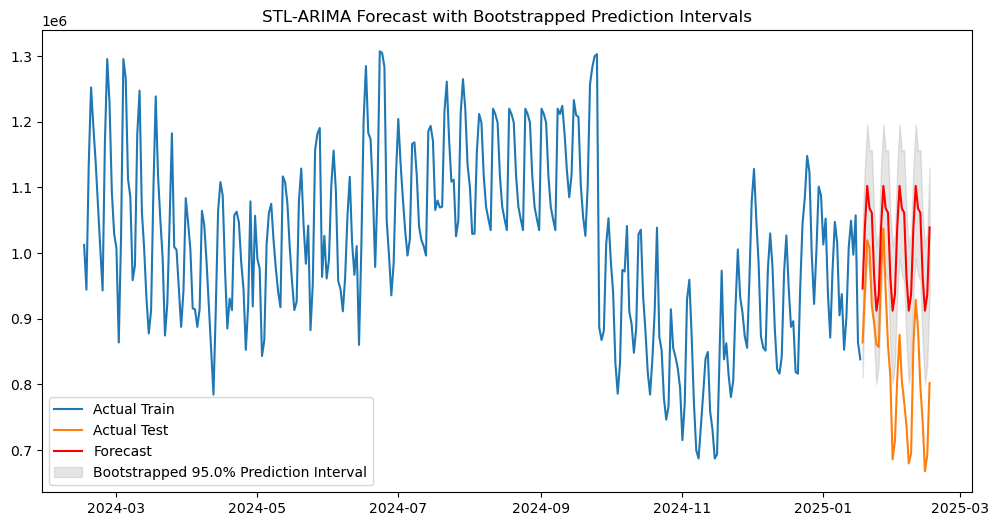

In [71]:
# 5. Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Revenue Losses'], label='Actual Train')
plt.plot(test_df['Date'], test_df['Revenue Losses'], label='Actual Test')
plt.plot(test_df['Date'], test_forecast, label='Forecast', color='red')  # Original forecast

plt.fill_between(test_df['Date'], lower_bounds, upper_bounds, color='gray', alpha=0.2, label=f'Bootstrapped {100*(1-alpha)}% Prediction Interval')

plt.title('STL-ARIMA Forecast with Bootstrapped Prediction Intervals')
plt.legend()
plt.show()

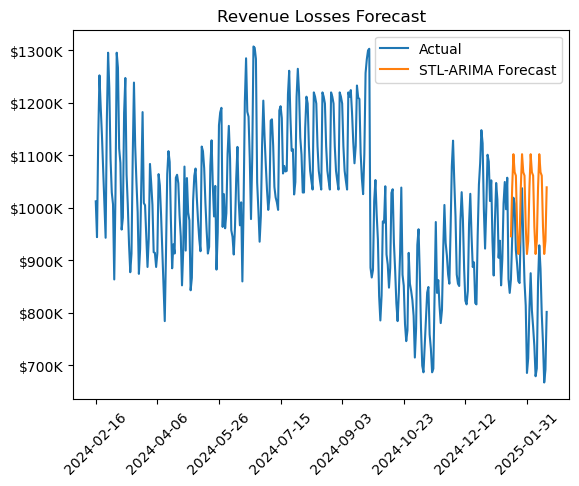

MAE: 173157.38192619724
RMSE: 188371.0876772521


In [72]:
plt.plot(df['Revenue Losses'], label="Actual")
plt.plot(test_forecast, label="STL-ARIMA Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE, RMSE on test set
mae = mean_absolute_error(test_df['Revenue Losses'], test_forecast)
rmse = root_mean_squared_error(test_df['Revenue Losses'], test_forecast)
print('MAE:', mae)
print('RMSE:', rmse)

NOTES.